In [81]:
import pandas as pd

Emission_data = pd.read_excel("Emissions_Data_Analysis.xlsx", sheet_name="Data", header=0)
print(Emission_data.head(3))

   CompanyID OperatingCountry             GICS_Sector  \
0  MFID_0001               FI  Consumer Discretionary   
1  MFID_0002               US             Industrials   
2  MFID_0003               US             Industrials   

                            GICS_Industry Group            GICS_Industry  \
0  Consumer Discretionary Distribution & Retail         Broadline Retail   
1                                Transportation  Air Freight & Logistics   
2                                 Capital Goods                Machinery   

                               GICS_SubIndustry  MarketCap_USD  \
0                              Broadline Retail   9.009218e+08   
1                       Air Freight & Logistics   7.805002e+09   
2  Industrial Machinery & Supplies & Components   4.250030e+09   

  MarketCap_Class    Sales_USD  Scope12_CarbonEmissions  ...  \
0       Small-cap   302.918892             12417.319222  ...   
1         Mid-cap  8502.990086            397530.941716  ...   
2        

In [82]:
# Find all columns for Scope 3 categories (1 to 15)
scope3_category_cols = [col for col in Emission_data.columns if col.startswith("Scope3_CarbonEmissions_Cat_")]

# Sum them to get total Scope 3 emissions from all 15 categories
Emission_data["Scope3_Sum_Categories"] = Emission_data[scope3_category_cols].sum(axis=1)

print(Emission_data[["Scope3_Sum_Categories"]])

      Scope3_Sum_Categories
0              6.086799e+04
1              1.728498e+06
2              7.420561e+05
3              1.483363e+06
4              3.620477e+07
...                     ...
8391           3.685801e+05
8392           1.565456e+07
8393           1.792645e+08
8394           2.399803e+07
8395           3.007605e+06

[8396 rows x 1 columns]


In [83]:
Emission_data['Scope3_Discrepancy'] = Emission_data['Scope3_CarbonEmissions_Estimated'] - Emission_data['Scope3_Sum_Categories']
Emission_data['Scope3_Relative_Discrepancy'] = Emission_data['Scope3_Discrepancy'] / (Emission_data['Scope3_CarbonEmissions_Estimated'] + 1e-6)

# Filter normal-range companies
mask = (
    (Emission_data['Scope3_CarbonEmissions_Estimated'] > 0) &
    (Emission_data['Scope3_Sum_Categories'] > 0) &
    (Emission_data['Scope3_Relative_Discrepancy'].abs() <= 0.3)
)
Emission_data = Emission_data[mask]

# Count the companies left after filtering where the sum of 15 categories of scope 3 emissions is within 30% discrepancy of the total model estimated Scope 3 emissions
print(len(Emission_data))

8175


In [84]:
# Adjusted Scope 3: weighted average of scope3 emissions favoring model estimate over category sum
Emission_data['Adjusted_Est_Scope3'] = (
    0.8 * Emission_data['Scope3_CarbonEmissions_Estimated'] +
    0.2 * Emission_data['Scope3_Sum_Categories']
)

# Compare reported emissions to adjusted emissions, taking the maximum value from both
# We do not assume that reported emissions are always more accurate (since companies may have an incentive to report lower values) or that estimated emissions are always precise.
# By taking the maximum of the two, we avoid underestimating emissions.
Emission_data['Scope3_Emissions'] = Emission_data[['Adjusted_Est_Scope3', 'Scope3_CarbonEmissions_Reported']].max(axis=1)

# Total emissions from Scope 1, 2, and 3
Emission_data['Total_Emissions'] = Emission_data['Scope3_Emissions'] + Emission_data['Scope12_CarbonEmissions']

# Group by sector and sum total emissions
Sector_sum_of_total_emissions = Emission_data.groupby('GICS_Sector')['Total_Emissions'].sum().sort_values(ascending=False)
Sector_sum_of_total_emissions.name = 'Total_Emissions (tCO2e)'

print(Sector_sum_of_total_emissions.head())
print(f"The highest sector is {Sector_sum_of_total_emissions.idxmax()}.")

GICS_Sector
Energy                    3.074004e+10
Industrials               2.253556e+10
Materials                 1.893768e+10
Consumer Discretionary    1.275764e+10
Financials                1.066661e+10
Name: Total_Emissions (tCO2e), dtype: float64
The highest sector is Energy.


In [85]:
# Group by market cap class and get stats
Emission_data = Emission_data[
    Emission_data['MarketCap_USD'].notna() & (Emission_data['MarketCap_USD'] != 0)
]

# Calculate intensity metrics of emissions in every company
Emission_data['Scope3_Emissions_per_MarketCap'] = (
    Emission_data['Scope3_Emissions'] / Emission_data['MarketCap_USD']
)

Emission_data['Total_Emissions_per_MarketCap'] = (
    Emission_data['Total_Emissions'] / Emission_data['MarketCap_USD']
)

# Define aggregation stats
summary_stats = ['mean', 'median', 'var', 'count']

# Group and describe Scope 3 and Total Emissions per Market Cap
scope3_emission_statistics = (
    Emission_data.groupby('MarketCap_Class')['Scope3_Emissions_per_MarketCap']
    .agg(summary_stats)
    .sort_values(by='mean', ascending=False)
)
total_emission_statistics = (
    Emission_data.groupby('MarketCap_Class')['Total_Emissions_per_MarketCap']
    .agg(summary_stats)
    .sort_values(by='mean', ascending=False)
)

print("Scope 3 Emissions per Market Cap:")
print(scope3_emission_statistics)

print("\nTotal Emissions per Market Cap:")
print(total_emission_statistics)


Scope 3 Emissions per Market Cap:
                     mean    median       var  count
MarketCap_Class                                     
Micro-cap        0.024624  0.001705  0.004356     21
Small-cap        0.001925  0.000355  0.000096   2198
Mid-cap          0.001425  0.000242  0.000030   3155
Large-cap        0.001211  0.000228  0.000028   2491
Mega-cap         0.000639  0.000099  0.000001    106

Total Emissions per Market Cap:
                     mean    median       var  count
MarketCap_Class                                     
Micro-cap        0.032586  0.002779  0.006965     20
Small-cap        0.002236  0.000458  0.000102   2197
Mid-cap          0.001782  0.000306  0.000036   3152
Large-cap        0.001459  0.000270  0.000031   2490
Mega-cap         0.000676  0.000113  0.000001    106


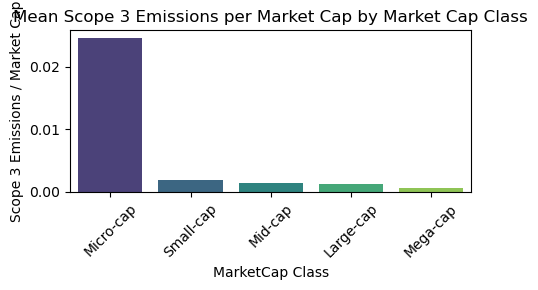

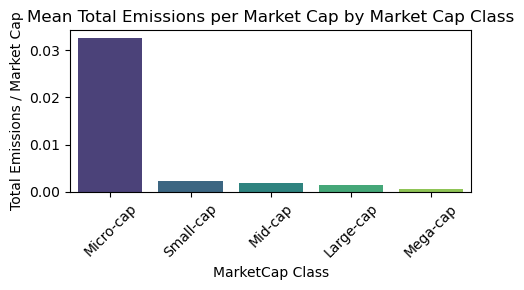

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emission_bar(data, value_col, group_col='MarketCap_Class', title='', ylabel=''):
    """Barplot function for emissions per market cap class."""
    plot_data = (
        data.groupby(group_col)[value_col]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )

    plt.figure(figsize=(5, 3))
    sns.barplot(data=plot_data, x=group_col, y=value_col, palette='viridis')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(group_col.replace('_', ' '))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_emission_bar(
    Emission_data,
    value_col='Scope3_Emissions_per_MarketCap',
    title='Mean Scope 3 Emissions per Market Cap by Market Cap Class',
    ylabel='Scope 3 Emissions / Market Cap'
)

plot_emission_bar(
    Emission_data,
    value_col='Total_Emissions_per_MarketCap',
    title='Mean Total Emissions per Market Cap by Market Cap Class',
    ylabel='Total Emissions / Market Cap'
)


In [ ]:

Emission_data["Categories_4_and_9_in_total_scope3_emissions"] = Emission_data['Scope3_CarbonEmissions_Cat_4_9']/Emission_data['Scope3_Emissions']
mean_ratio = Emission_data["Categories_4_and_9_in_total_scope3_emissions"].mean()
print(f"The mean share of combined Category 4 and 9 emissions in total Scope 3 emissions is {mean_ratio:.2%}. This combined value can be further attributed to Category 4 (upstream) and Category 9 (downstream) emissions by division.")
Emission_data[scope3_category_cols] = Emission_data[scope3_category_cols].fillna(0)
cat_4_9_split = Emission_data['Scope3_CarbonEmissions_Cat_4_9'] / 2

upstream_cols = [
    'Scope3_CarbonEmissions_Cat_1_2',
    'Scope3_CarbonEmissions_Cat_3',
    'Scope3_CarbonEmissions_Cat_5',
    'Scope3_CarbonEmissions_Cat_6',
    'Scope3_CarbonEmissions_Cat_7',
    'Scope3_CarbonEmissions_Cat_8'
]

downstream_cols = [
    'Scope3_CarbonEmissions_Cat_10',
    'Scope3_CarbonEmissions_Cat_11',
    'Scope3_CarbonEmissions_Cat_12',
    'Scope3_CarbonEmissions_Cat_13',
    'Scope3_CarbonEmissions_Cat_14',
    'Scope3_CarbonEmissions_Cat_15'
]

# Compute emissions by upstream and downstream categories
Emission_data['Upstream_Emissions'] = Emission_data[upstream_cols].sum(axis=1) + cat_4_9_split
Emission_data['Downstream_Emissions'] = Emission_data[downstream_cols].sum(axis=1) + cat_4_9_split

upstream_downstream_statistics = Emission_data[['Upstream_Emissions', 'Downstream_Emissions']].describe()
print(upstream_downstream_statistics)

# Aggregate by sector
emission_by_sector_highest_upstream = Emission_data.groupby('GICS_Sector')[['Upstream_Emissions']].sum().sort_values(by='Upstream_Emissions', ascending=False)
emission_by_sector_highest_downstream = Emission_data.groupby('GICS_Sector')[['Downstream_Emissions']].sum().sort_values(by='Downstream_Emissions', ascending=False)


print(f"Sector with highest upstream emissions: {emission_by_sector_highest_upstream.index[0]}")
print(f"Sector with highest downstream emissions: {emission_by_sector_highest_downstream.index[0]}")

The mean share of combined Category 4 and 9 emissions in total Scope 3 emissions is 4.31%. This combined value can be further attributed to Category 4 (upstream) and Category 9 (downstream) emissions by division.
       Upstream_Emissions  Downstream_Emissions
count        7.971000e+03          7.971000e+03
mean         3.803177e+06          1.167135e+07
std          1.109861e+07          6.746476e+07
min          2.852541e+01          2.755913e+00
25%          2.184845e+05          2.361076e+04
50%          7.499548e+05          2.206541e+05
75%          2.646594e+06          1.853462e+06
max          2.039570e+08          2.191219e+09
                        Upstream_Emissions
GICS_Sector                               
Consumer Discretionary        3.045489e+09
Materials                     2.927683e+09
Consumer Staples              2.648442e+09
Industrials                   2.583085e+09
Energy                        2.148282e+09
Financials                    1.818577e+09
Information